# LGBM + Deberta 

In [1]:
import gc
import torch
import copy
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,DataCollatorWithPadding
import nltk
from datasets import Dataset
from glob import glob
import numpy as np 
import pandas as pd
import polars as pl
import re
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.special import softmax
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import cohen_kappa_score
from lightgbm import log_evaluation, early_stopping
import lightgbm as lgb
nltk.download('wordnet')

2024-05-20 16:34:18.435168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 16:34:18.435310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 16:34:18.562284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

---

**Explaination**


1. `MAX_LENGTH`: Maximum length of the input sequence. Set it to 1024 tokens.

2. `TEST_DATA_PATH`: Path to the test data CSV file. 

3. `MODEL_PATH`: Path to the directory containing the trained models.

4. `EVAL_BATCH_SIZE`: Batch size used for evaluation. Set it to 1, meaning each evaluation batch contains a single sample.



In [2]:
MAX_LENGTH = 1024
TEST_DATA_PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv"
MODEL_PATH = '/kaggle/input/aes2-400-20240419134941/*/*'
EVAL_BATCH_SIZE = 1

## Tokenization and Dataset Preparation

In [ ]:
models = glob(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(models[0])

def tokenize(sample):
    return tokenizer(sample['full_text'], max_length=MAX_LENGTH, truncation=True)

df_test = pd.read_csv(TEST_DATA_PATH)
ds = Dataset.from_pandas(df_test).map(tokenize).remove_columns(['essay_id', 'full_text'])

args = TrainingArguments(
    ".", 
    per_device_eval_batch_size=EVAL_BATCH_SIZE, 
    report_to="none"
)

predictions = []
for model in models:
    model = AutoModelForSequenceClassification.from_pretrained(model)
    trainer = Trainer(
        model=model, 
        args=args, 
        data_collator=DataCollatorWithPadding(tokenizer), 
        tokenizer=tokenizer
    )    
    preds = trainer.predict(ds).predictions
    predictions.append(softmax(preds, axis=-1))
    del model, trainer
    torch.cuda.empty_cache()
    gc.collect()

## Model Loading and Evaluation Setup

In [4]:
predicted_score = 0.
for p in predictions:
    predicted_score += p
    
predicted_score /= len(predictions)

## Generating Predictions for Test Data

In [5]:
df_test['score'] = predicted_score.argmax(-1) + 1


In [6]:
df_test[['essay_id', 'score']].to_csv('submission1.csv', index=False)

# Data Loading



In [7]:
columns = [  
    (
        pl.col("full_text").str.split(by="\n\n").alias("paragraph")
    ),
]
PATH = "/kaggle/input/learning-agency-lab-automated-essay-scoring-2/"

train = pl.read_csv(PATH + "train.csv").with_columns(columns)
test = pl.read_csv(PATH + "test.csv").with_columns(columns)



## Spelling Error Count Function

In [8]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")
with open('/kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)
def count_spelling_errors(text):

    
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]

    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)


    return spelling_errors



# Contraction Expansion and Text Preprocessing Functions 

In [9]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
def dataPreprocessing(x):
    x = x.lower()
    x = removeHTML(x)
    x = re.sub("@\w+", '',x)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub("http\w+", '',x)
    x = re.sub(r"\s+", " ", x)
#     x = expandContractions(x)
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    x = x.strip()
    return x

# Punctuation Removal Function

In [10]:
import string

def remove_punctuation(text):

    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

text = "Hello, world! This is a test."
print(remove_punctuation(text))


Hello world This is a test


# Paragraph Preprocessing

In [11]:

def Paragraph_Preprocess(tmp):
    tmp = tmp.explode('paragraph')
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)

    return tmp
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_>{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_<{i}_cnt") for i in [25,49]], 

        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],  # 求四分之一值
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],  # 求四分之三值
    
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)
train_feats['score'] = train['score']

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))


Features Number:  53


# Sentence Preprocessing

In [12]:
def Sentence_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))

    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_>{i}_cnt") for i in [0,15,50,100,150,200,250,300] ], 
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15,50] ], 

        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea],  
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea],  
    
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Sentence_Preprocess(train)
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))


Features Number:  81


In [13]:
pd.options.display.max_columns = None

In [14]:
train_feats

,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,paragraph_>300_cnt,paragraph_>350_cnt,paragraph_>400_cnt,paragraph_>500_cnt,paragraph_>600_cnt,paragraph_>700_cnt,paragraph_<25_cnt,paragraph_<49_cnt,paragraph_error_num_max,paragraph_len_max,paragraph_sentence_cnt_max,paragraph_word_cnt_max,paragraph_error_num_mean,paragraph_len_mean,paragraph_sentence_cnt_mean,paragraph_word_cnt_mean,paragraph_error_num_min,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_error_num_sum,paragraph_len_sum,paragraph_sentence_cnt_sum,paragraph_word_cnt_sum,paragraph_error_num_first,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_error_num_last,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,paragraph_error_num_kurtosis,paragraph_len_kurtosis,paragraph_sentence_cnt_kurtosis,paragraph_word_cnt_kurtosis,paragraph_error_num_q1,paragraph_len_q1,paragraph_sentence_cnt_q1,paragraph_word_cnt_q1,paragraph_error_num_q3,paragraph_len_q3,paragraph_sentence_cnt_q3,paragraph_word_cnt_q3,score,sentence_>0_cnt,sentence_>15_cnt,sentence_>50_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_<15_cnt,sentence_<50_cnt,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_sum,sentence_word_cnt_sum,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last,sentence_len_kurtosis,sentence_word_cnt_kurtosis,sentence_len_q1,sentence_word_cnt_q1,sentence_len_q3,sentence_word_cnt_q3
0,000d118,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,27,2640,14,491,27.000000,2640.000000,14.000000,491.000000,27,2640,14,491,27,2640,14,491,27,2640,14,491,27,2640,14,491,NaN,NaN,NaN,NaN,27.0,2640.0,14.0,491.0,27.0,2640.0,14.0,491.0,3,14,13,11,11,7,4,3,3,1,3,593,127,187.642857,36.000000,0,1,2627,504,36,7,0,1,1.438632,2.175806,109.0,19.0,225.0,37.0
1,000fe60,5,5,5,5,5,5,5,4,3,3,2,1,0,0,0,0,0,2,499,6,98,1.000000,331.800000,4.400000,66.400000,0,184,3,37,5,1659,22,332,1,184,4,37,1,235,3,46,-0.500000,-1.315965,-1.044379,-1.388460,1.0,235.0,4.0,46.0,1.0,398.0,5.0,77.0,3,18,17,15,8,3,1,1,0,1,3,250,49,91.444444,19.388889,0,1,1646,349,62,13,0,1,0.917062,0.505776,51.0,12.0,124.0,25.0
2,001ab80,4,4,4,4,4,4,4,4,4,4,4,4,3,2,2,0,0,2,1083,10,199,1.250000,765.500000,7.000000,137.500000,0,476,5,85,5,3062,28,550,0,576,5,101,2,476,5,85,-1.371901,-1.740076,-1.592593,-1.696723,1.0,576.0,5.0,101.0,2.0,927.0,8.0,165.0,4,25,24,24,15,7,1,0,0,1,1,237,47,121.640000,22.960000,0,1,3041,574,144,27,0,1,-0.004393,0.270079,86.0,17.0,151.0,29.0
3,001bdc0,5,5,5,5,5,4,4,4,4,4,4,2,2,2,2,0,0,6,975,8,163,2.400000,534.000000,5.000000,89.200000,0,129,2,25,12,2670,25,446,2,395,2,64,0,366,5,67,-1.371972,-1.449616,-1.750000,-1.321913,0.0,366.0,2.0,64.0,4.0,805.0,8.0,127.0,4,21,20,19,10,6,3,1,1,1,2,394,64,126.380952,22.190476,0,1,2654,466,394,64,0,1,3.148141,2.512804,77.0,15.0,171.0,29.0
4,002ba53,6,4,4,4,4,4,4,4,4,4,4,3,3,1,0,2,2,5,689,6,118,2.333333,363.166667,3.500000,62.166667,0,17,1,2,14,2179,21,373,0,19,1,3,1,17,1,2,-1.488980,-1.475737,-1.616116,-1.457252,1.0,19.0,1.0,3.0,5.0,559.0,5.0,93.0,3,16,16,15,10,5,2,2,1,0,1,440,76,135.562500,24.250000,18,3,2169,388,87,16,18,3,3.677503,3.761004,87.0,16.0,151.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17302,ffd378d,3,3,3,3,3,2,2,2,2,1,1,1,0,0,0,0,0,9,443,5,82,4.333333,284.000000,4.000000,52.333333,0,136,3,23,13,852,12,157,9,443,4,82,0,136,3,23,-1.500000,-1.500000,-1.500000,-1.500000,4.0,273.0,4.0,52.0,9.0,443.0,5.0,82.0,2,10,9,7,4,1,0,0,0,1,3,19

common calculation

tokens = preprocess_text(text)

sent_tokenize(text)

word_tokenize(text)

doc = nlp(text)


# Word Preprocessing

In [15]:
def Word_Preprocess(tmp):
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp
def Word_Eng(train_tmp):
    aggs = [
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

tmp = Word_Preprocess(train)
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))


Features Number:  102


In [16]:
train_feats

,essay_id,paragraph_>0_cnt,paragraph_>50_cnt,paragraph_>75_cnt,paragraph_>100_cnt,paragraph_>125_cnt,paragraph_>150_cnt,paragraph_>175_cnt,paragraph_>200_cnt,paragraph_>250_cnt,paragraph_>300_cnt,paragraph_>350_cnt,paragraph_>400_cnt,paragraph_>500_cnt,paragraph_>600_cnt,paragraph_>700_cnt,paragraph_<25_cnt,paragraph_<49_cnt,paragraph_error_num_max,paragraph_len_max,paragraph_sentence_cnt_max,paragraph_word_cnt_max,paragraph_error_num_mean,paragraph_len_mean,paragraph_sentence_cnt_mean,paragraph_word_cnt_mean,paragraph_error_num_min,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_error_num_sum,paragraph_len_sum,paragraph_sentence_cnt_sum,paragraph_word_cnt_sum,paragraph_error_num_first,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_error_num_last,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last,paragraph_error_num_kurtosis,paragraph_len_kurtosis,paragraph_sentence_cnt_kurtosis,paragraph_word_cnt_kurtosis,paragraph_error_num_q1,paragraph_len_q1,paragraph_sentence_cnt_q1,paragraph_word_cnt_q1,paragraph_error_num_q3,paragraph_len_q3,paragraph_sentence_cnt_q3,paragraph_word_cnt_q3,score,sentence_>0_cnt,sentence_>15_cnt,sentence_>50_cnt,sentence_>100_cnt,sentence_>150_cnt,sentence_>200_cnt,sentence_>250_cnt,sentence_>300_cnt,sentence_<15_cnt,sentence_<50_cnt,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_sum,sentence_word_cnt_sum,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last,sentence_len_kurtosis,sentence_word_cnt_kurtosis,sentence_len_q1,sentence_word_cnt_q1,sentence_len_q3,sentence_word_cnt_q3,word_1_cnt,word_2_cnt,word_3_cnt,word_4_cnt,word_5_cnt,word_6_cnt,word_7_cnt,word_8_cnt,word_9_cnt,word_10_cnt,word_11_cnt,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,27,2640,14,491,27.000000,2640.000000,14.000000,491.000000,27,2640,14,491,27,2640,14,491,27,2640,14,491,27,2640,14,491,NaN,NaN,NaN,NaN,27.0,2640.0,14.0,491.0,27.0,2640.0,14.0,491.0,3,14,13,11,11,7,4,3,3,1,3,593,127,187.642857,36.000000,0,1,2627,504,36,7,0,1,1.438632,2.175806,109.0,19.0,225.0,37.0,491,471,391,289,169,119,76,46,32,21,14,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,5,4,3,3,2,1,0,0,0,0,0,2,499,6,98,1.000000,331.800000,4.400000,66.400000,0,184,3,37,5,1659,22,332,1,184,4,37,1,235,3,46,-0.500000,-1.315965,-1.044379,-1.388460,1.0,235.0,4.0,46.0,1.0,398.0,5.0,77.0,3,18,17,15,8,3,1,1,0,1,3,250,49,91.444444,19.388889,0,1,1646,349,62,13,0,1,0.917062,0.505776,51.0,12.0,124.0,25.0,332,311,248,184,103,63,41,29,16,4,1,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,4,4,4,3,2,2,0,0,2,1083,10,199,1.250000,765.500000,7.000000,137.500000,0,476,5,85,5,3062,28,550,0,576,5,101,2,476,5,85,-1.371901,-1.740076,-1.592593,-1.696723,1.0,576.0,5.0,101.0,2.0,927.0,8.0,165.0,4,25,24,24,15,7,1,0,0,1,1,237,47,121.640000,22.960000,0,1,3041,574,144,27,0,1,-0.004393,0.270079,86.0,17.0,151.0,29.0,550,539,445,328,200,135,103,72,54,40,19,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0
3,001bdc0,5,5,5,5,5,4,4,4,4,4,4,2,2,2,2,0,0,6,975,8,163,2.400000,534.000000,5.000000,89.200000,0,129,2,25,12,2670,25,446,2,395,2,64,0,366,5,67,-1.371972,-1.449616,-1.750000,-1.321913,0.0,366.0,2.0,64.0,4.0,805.0,8.0,127.0,4,21,20,19,10,6,3,1,1,1,2,394,64,126.380952,22.190476,0,1,2654,466,394,64,0,1,3.148141,2.512804,77.0,15.0,171.0,29.0,446,431,348,277,217,175,133,85,51,33,18,9,2,1,1,17,4.997758,2.767791,3.0,4.0,7.0
4,002ba53,6,4,4,4,4,4,4,4,4,4,4,3,3,1,0,2,2,5,689,6,118,2.333333,363.166667,3.500000,62.166667,0,17,1,2,14,2179,21,373,0,19,1,3,1,17,1,2,-1.488980,-1.475737,-1.616116,-1.457252,1.0,19.0,1.0,3.0,5.0,559.0,5.0,93.0,3,16,16,15,10,5,2,2,1,0,1,440,76,135.562500,24.250000,18,3,2169,388,87,16,18,3,3.677503,3.761004,87.0,16.0,151.0,26.0,373,354,280,213,

# Tf-idf Vectorizer Setup and Feature Engineering

In [17]:
vectorizer = TfidfVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(3,6),
            min_df=0.05,
            max_df=0.95,
            sublinear_tf=True,
)

train_tfid = vectorizer.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Number of Features: ', len(feature_names))


Number of Features:  19729


# CountVectorizer Setup and Feature Engineering

In [18]:
vectorizer_cnt = CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=lambda x: x,
            token_pattern=None,
            strip_accents='unicode',
            analyzer = 'word',
            ngram_range=(2,3),
            min_df=0.10,
            max_df=0.85,
)
train_tfid = vectorizer_cnt.fit_transform([i for i in train['full_text']])
dense_matrix = train_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = train_feats['essay_id']
train_feats = train_feats.merge(df, on='essay_id', how='left')
print('Number of Features: ', len(feature_names))

Number of Features:  19729


# Deberta Embeddings and Model Evaluation Setup

In [19]:
import joblib

deberta_oof = joblib.load('/kaggle/input/aes2-400-20240419134941/oof.pkl')
print(deberta_oof.shape, train_feats.shape)

for i in range(6):
    train_feats[f'deberta_oof_{i}'] = deberta_oof[:, i]

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))    

train_feats.shape

(17307, 6) (17307, 21901)
Features Number:  21905


(17307, 21907)

# QWK Metric Definitions and Parameters 

In [20]:
def quadratic_weighted_kappa(y_true, y_pred):
    y_true = y_true + a
    y_pred = (y_pred + a).clip(1, 6).round()
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    return 'QWK', qwk, True
def qwk_obj(y_true, y_pred):
    labels = y_true + a
    preds = y_pred + a
    preds = preds.clip(1, 6)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-a)**2+b)
    df = preds - labels
    dg = preds - a
    grad = (df/g - f*dg/g**2)*len(labels)
    hess = np.ones(len(labels))
    return grad, hess
a = 2.998
b = 1.092


## Data Preparation for Model Training

In [21]:
X = train_feats[feature_names].astype(np.float32).values

y_split = train_feats['score'].astype(int).values
y = train_feats['score'].astype(np.float32).values-a
oof = train_feats['score'].astype(int).values

In [22]:
len(feature_names)

21905

# Feature Selection Wrapper Function

In [23]:
def feature_select_wrapper():

    features = feature_names

    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fse = pd.Series(0, index=features)
    
        
        
    for train_index, test_index in skf.split(X, y_split):

        X_train_fold, X_test_fold = X[train_index], X[test_index]


        y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]

        model = lgb.LGBMRegressor(
                    objective = qwk_obj,
                    metrics = 'None',
                    learning_rate = 0.01,
                    max_depth = 5,
                    num_leaves = 10,
                    colsample_bytree=0.3,
                    reg_alpha = 0.7,
                    reg_lambda = 0.1,
                    n_estimators=700,
                    random_state=412,
                    extra_trees=True,
                    class_weight='balanced',
                    verbosity = - 1)

        predictor = model.fit(X_train_fold,
                                      y_train_fold,
                                      eval_names=['train', 'valid'],
                                      eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                      eval_metric=quadratic_weighted_kappa,
                                      callbacks=callbacks,)
        models.append(predictor)
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        oof[test_index]=predictions_fold
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)


        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)

        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        disp.plot()
        plt.show()
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')

        fse += pd.Series(predictor.feature_importances_, features)
    
    
    
    feature_select = fse.sort_values(ascending=False).index.tolist()[:13000]
    return feature_select

## Model Training and Evaluation Loop

[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.220265	valid's QWK: 0.208446
[50]	train's QWK: 0.665386	valid's QWK: 0.662639
[75]	train's QWK: 0.716286	valid's QWK: 0.705951
[100]	train's QWK: 0.752775	valid's QWK: 0.74284
[125]	train's QWK: 0.773893	valid's QWK: 0.7605
[150]	train's QWK: 0.793284	valid's QWK: 0.773169
[175]	train's QWK: 0.807843	valid's QWK: 0.781234
[200]	train's QWK: 0.816081	valid's QWK: 0.795243
[225]	train's QWK: 0.823084	valid's QWK: 0.804197
[250]	train's QWK: 0.826407	valid's QWK: 0.810291
[275]	train's QWK: 0.828855	valid's QWK: 0.812315
[300]	train's QWK: 0.831284	valid's QWK: 0.815446
[325]	train's QWK: 0.83316	valid's QWK: 0.818442
[350]	train's QWK: 0.835148	valid's QWK: 0.821333
[375]	train's QWK: 0.836698	valid's QWK: 0.82202
[400]	train's QWK: 0.837828	valid's QWK: 0.822508
[425]	train's QWK: 0.838923	valid's QWK: 0.823394
[450]	train's QWK: 0.840105	valid's QWK: 

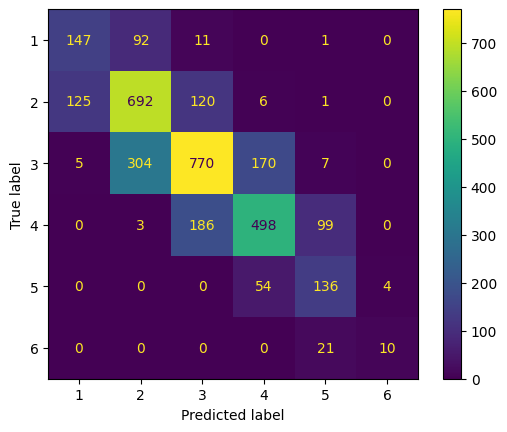

F1 score across fold: 0.6508182340054838
Cohen kappa score across fold: 0.8311790888875621
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.234465	valid's QWK: 0.217869
[50]	train's QWK: 0.662717	valid's QWK: 0.647863
[75]	train's QWK: 0.718624	valid's QWK: 0.706513
[100]	train's QWK: 0.756401	valid's QWK: 0.749783
[125]	train's QWK: 0.774953	valid's QWK: 0.768223
[150]	train's QWK: 0.79427	valid's QWK: 0.788119
[175]	train's QWK: 0.80783	valid's QWK: 0.800499
[200]	train's QWK: 0.817161	valid's QWK: 0.809554
[225]	train's QWK: 0.823245	valid's QWK: 0.817534
[250]	train's QWK: 0.826155	valid's QWK: 0.821567
[275]	train's QWK: 0.829018	valid's QWK: 0.824588
[300]	train's QWK: 0.831214	valid's QWK: 0.826424
[325]	train's QWK: 0.833442	valid's QWK: 0.830304
[350]	train's QWK: 0.835624	valid's QWK: 0.831351
[375]	train's QWK: 0.836729	valid's QWK: 0.832745
[400]	train's QWK: 0.837719	valid's QWK: 0.8334

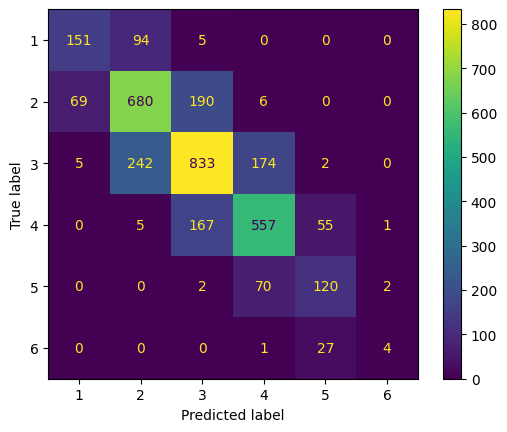

F1 score across fold: 0.6753907933183307
Cohen kappa score across fold: 0.8376299496432653
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.230516	valid's QWK: 0.224394
[50]	train's QWK: 0.668502	valid's QWK: 0.647248
[75]	train's QWK: 0.716737	valid's QWK: 0.696878
[100]	train's QWK: 0.755251	valid's QWK: 0.740166
[125]	train's QWK: 0.775644	valid's QWK: 0.758367
[150]	train's QWK: 0.790946	valid's QWK: 0.775757
[175]	train's QWK: 0.805959	valid's QWK: 0.789586
[200]	train's QWK: 0.816501	valid's QWK: 0.797141
[225]	train's QWK: 0.82396	valid's QWK: 0.804175
[250]	train's QWK: 0.828985	valid's QWK: 0.807318
[275]	train's QWK: 0.831663	valid's QWK: 0.809427
[300]	train's QWK: 0.833093	valid's QWK: 0.81208
[325]	train's QWK: 0.83458	valid's QWK: 0.814249
[350]	train's QWK: 0.836737	valid's QWK: 0.816071
[375]	train's QWK: 0.838022	valid's QWK: 0.817635
[400]	train's QWK: 0.839519	valid's QWK: 0.81773

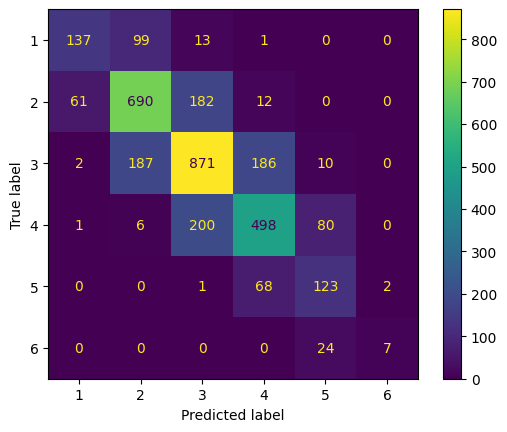

F1 score across fold: 0.6708590029330558
Cohen kappa score across fold: 0.8255085140019336
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.231824	valid's QWK: 0.228194
[50]	train's QWK: 0.667568	valid's QWK: 0.666908
[75]	train's QWK: 0.715992	valid's QWK: 0.720596
[100]	train's QWK: 0.755459	valid's QWK: 0.754418
[125]	train's QWK: 0.772968	valid's QWK: 0.772231
[150]	train's QWK: 0.787776	valid's QWK: 0.788392
[175]	train's QWK: 0.80274	valid's QWK: 0.796664
[200]	train's QWK: 0.813235	valid's QWK: 0.807236
[225]	train's QWK: 0.819135	valid's QWK: 0.816295
[250]	train's QWK: 0.823797	valid's QWK: 0.821797
[275]	train's QWK: 0.827189	valid's QWK: 0.822206
[300]	train's QWK: 0.829672	valid's QWK: 0.825574
[325]	train's QWK: 0.832893	valid's QWK: 0.826775
[350]	train's QWK: 0.834734	valid's QWK: 0.827478
[375]	train's QWK: 0.83735	valid's QWK: 0.828317
[400]	train's QWK: 0.838215	valid's QWK: 0.8288

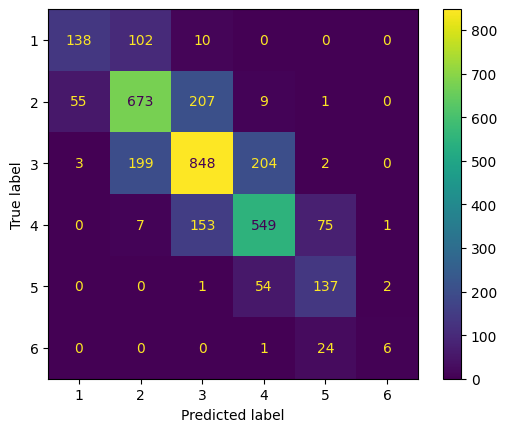

F1 score across fold: 0.677810484027938
Cohen kappa score across fold: 0.8351067165811705
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.248238	valid's QWK: 0.261975
[50]	train's QWK: 0.662414	valid's QWK: 0.680571
[75]	train's QWK: 0.714554	valid's QWK: 0.733872
[100]	train's QWK: 0.751738	valid's QWK: 0.763386
[125]	train's QWK: 0.771326	valid's QWK: 0.784007
[150]	train's QWK: 0.789045	valid's QWK: 0.801701
[175]	train's QWK: 0.803434	valid's QWK: 0.814807
[200]	train's QWK: 0.812147	valid's QWK: 0.822339
[225]	train's QWK: 0.820468	valid's QWK: 0.828396
[250]	train's QWK: 0.824715	valid's QWK: 0.831961
[275]	train's QWK: 0.827657	valid's QWK: 0.835394
[300]	train's QWK: 0.830085	valid's QWK: 0.836021
[325]	train's QWK: 0.832031	valid's QWK: 0.837173
[350]	train's QWK: 0.833523	valid's QWK: 0.837882
[375]	train's QWK: 0.835644	valid's QWK: 0.839404
[400]	train's QWK: 0.837094	valid's QWK: 0.839

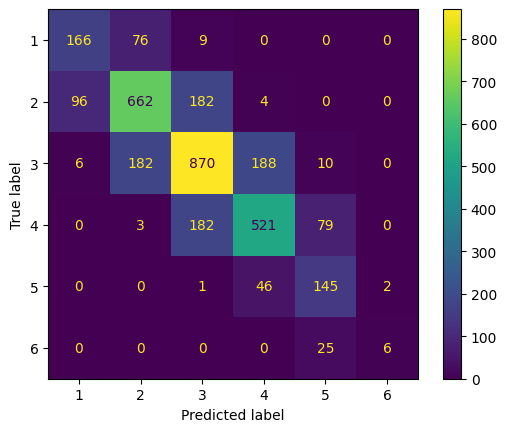

F1 score across fold: 0.6841059892623254
Cohen kappa score across fold: 0.844109543724264


In [24]:
f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
feature_select = feature_select_wrapper()

In [25]:
X = train_feats[feature_select].astype(np.float32).values

# Model Evaluation Metrics Calculation

fold 1
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.247056	valid's QWK: 0.240997
[50]	train's QWK: 0.670285	valid's QWK: 0.682018
[75]	train's QWK: 0.719144	valid's QWK: 0.713078
[100]	train's QWK: 0.756759	valid's QWK: 0.748481
[125]	train's QWK: 0.777911	valid's QWK: 0.76578
[150]	train's QWK: 0.79677	valid's QWK: 0.780241
[175]	train's QWK: 0.809407	valid's QWK: 0.79708
[200]	train's QWK: 0.815922	valid's QWK: 0.805102
[225]	train's QWK: 0.822061	valid's QWK: 0.81414
[250]	train's QWK: 0.824726	valid's QWK: 0.818916
[275]	train's QWK: 0.827254	valid's QWK: 0.818786
[300]	train's QWK: 0.829309	valid's QWK: 0.823325
[325]	train's QWK: 0.831279	valid's QWK: 0.824922
[350]	train's QWK: 0.833371	valid's QWK: 0.827717
[375]	train's QWK: 0.834661	valid's QWK: 0.829346
[400]	train's QWK: 0.836126	valid's QWK: 0.831161
[425]	train's QWK: 0.837318	valid's QWK: 0.831885
[450]	train's QWK: 0.839088	valid

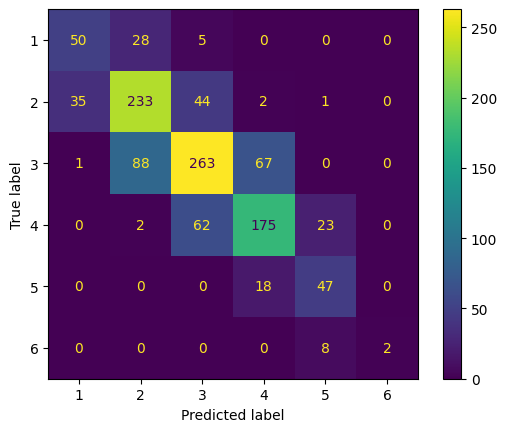

F1 score across fold: 0.6656898252053052
Cohen kappa score across fold: 0.8338635955805945
fold 2
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.236643	valid's QWK: 0.210226
[50]	train's QWK: 0.66752	valid's QWK: 0.6857
[75]	train's QWK: 0.718225	valid's QWK: 0.714782
[100]	train's QWK: 0.757819	valid's QWK: 0.760912
[125]	train's QWK: 0.777184	valid's QWK: 0.773184
[150]	train's QWK: 0.794687	valid's QWK: 0.785137
[175]	train's QWK: 0.808445	valid's QWK: 0.796314
[200]	train's QWK: 0.816406	valid's QWK: 0.809355
[225]	train's QWK: 0.821363	valid's QWK: 0.816276
[250]	train's QWK: 0.825332	valid's QWK: 0.818654
[275]	train's QWK: 0.827305	valid's QWK: 0.820577
[300]	train's QWK: 0.830147	valid's QWK: 0.826741
[325]	train's QWK: 0.831639	valid's QWK: 0.826329
[350]	train's QWK: 0.833289	valid's QWK: 0.828668
[375]	train's QWK: 0.834825	valid's QWK: 0.830724
[400]	train's QWK: 0.835724	valid's QWK: 

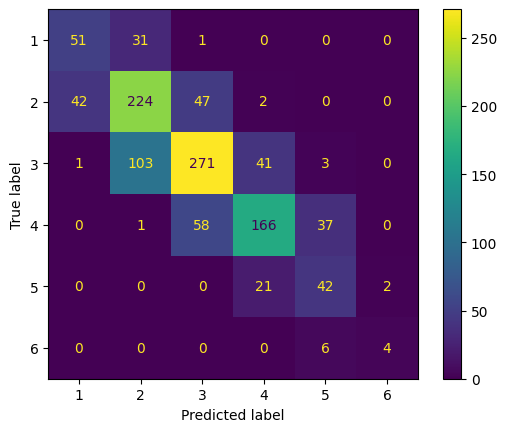

F1 score across fold: 0.6585696538354773
Cohen kappa score across fold: 0.8395368193276226
fold 3
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.238798	valid's QWK: 0.232826
[50]	train's QWK: 0.665033	valid's QWK: 0.671242
[75]	train's QWK: 0.717184	valid's QWK: 0.716445
[100]	train's QWK: 0.755827	valid's QWK: 0.748147
[125]	train's QWK: 0.77569	valid's QWK: 0.763334
[150]	train's QWK: 0.795221	valid's QWK: 0.774728
[175]	train's QWK: 0.80939	valid's QWK: 0.786442
[200]	train's QWK: 0.816649	valid's QWK: 0.801476
[225]	train's QWK: 0.822441	valid's QWK: 0.808438
[250]	train's QWK: 0.826625	valid's QWK: 0.808019
[275]	train's QWK: 0.829087	valid's QWK: 0.810335
[300]	train's QWK: 0.831511	valid's QWK: 0.813141
[325]	train's QWK: 0.832741	valid's QWK: 0.814117
[350]	train's QWK: 0.83417	valid's QWK: 0.815161
[375]	train's QWK: 0.836517	valid's QWK: 0.816432
[400]	train's QWK: 0.837476	valid's QWK: 

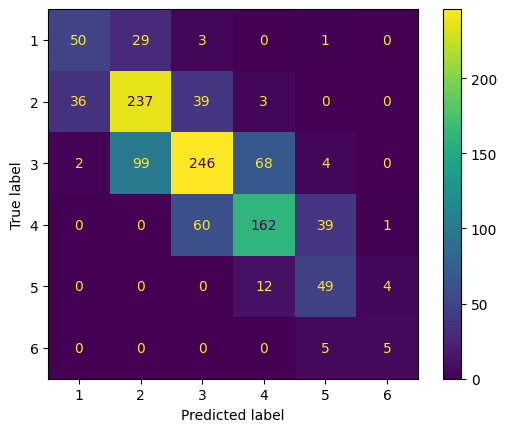

F1 score across fold: 0.6485226054616815
Cohen kappa score across fold: 0.8297378143762042
fold 4
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.180571	valid's QWK: 0.149901
[50]	train's QWK: 0.663987	valid's QWK: 0.661204
[75]	train's QWK: 0.719766	valid's QWK: 0.71207
[100]	train's QWK: 0.758007	valid's QWK: 0.75018
[125]	train's QWK: 0.774925	valid's QWK: 0.766452
[150]	train's QWK: 0.791928	valid's QWK: 0.785751
[175]	train's QWK: 0.804802	valid's QWK: 0.803007
[200]	train's QWK: 0.813712	valid's QWK: 0.812589
[225]	train's QWK: 0.820432	valid's QWK: 0.818284
[250]	train's QWK: 0.824353	valid's QWK: 0.823728
[275]	train's QWK: 0.826797	valid's QWK: 0.830441
[300]	train's QWK: 0.829334	valid's QWK: 0.832359
[325]	train's QWK: 0.83155	valid's QWK: 0.832495
[350]	train's QWK: 0.833123	valid's QWK: 0.832434
[375]	train's QWK: 0.834838	valid's QWK: 0.834632
[400]	train's QWK: 0.836655	valid's QWK: 

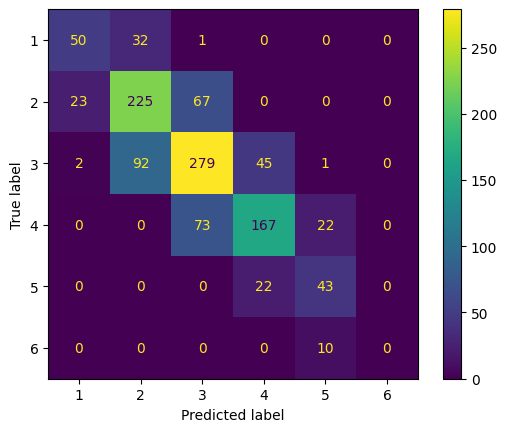

F1 score across fold: 0.6592294903998616
Cohen kappa score across fold: 0.8348699877195793
fold 5
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.213696	valid's QWK: 0.187679
[50]	train's QWK: 0.666046	valid's QWK: 0.669428
[75]	train's QWK: 0.722555	valid's QWK: 0.716657
[100]	train's QWK: 0.759573	valid's QWK: 0.754884
[125]	train's QWK: 0.778238	valid's QWK: 0.772809
[150]	train's QWK: 0.797088	valid's QWK: 0.784872
[175]	train's QWK: 0.807978	valid's QWK: 0.797538
[200]	train's QWK: 0.815815	valid's QWK: 0.806943
[225]	train's QWK: 0.821882	valid's QWK: 0.811301
[250]	train's QWK: 0.826343	valid's QWK: 0.817491
[275]	train's QWK: 0.828637	valid's QWK: 0.819524
[300]	train's QWK: 0.830861	valid's QWK: 0.824069
[325]	train's QWK: 0.832528	valid's QWK: 0.824835
[350]	train's QWK: 0.833947	valid's QWK: 0.827473
[375]	train's QWK: 0.835881	valid's QWK: 0.831894
[400]	train's QWK: 0.837485	valid's QW

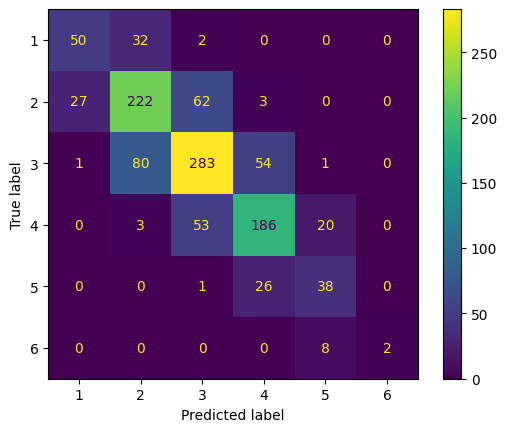

F1 score across fold: 0.6754994171212293
Cohen kappa score across fold: 0.8347756661179455
fold 6
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.213748	valid's QWK: 0.210424
[50]	train's QWK: 0.67444	valid's QWK: 0.667046
[75]	train's QWK: 0.722224	valid's QWK: 0.724559
[100]	train's QWK: 0.757775	valid's QWK: 0.765908
[125]	train's QWK: 0.776103	valid's QWK: 0.778883
[150]	train's QWK: 0.792852	valid's QWK: 0.79117
[175]	train's QWK: 0.806701	valid's QWK: 0.811161
[200]	train's QWK: 0.81498	valid's QWK: 0.821826
[225]	train's QWK: 0.819986	valid's QWK: 0.826778
[250]	train's QWK: 0.824854	valid's QWK: 0.832661
[275]	train's QWK: 0.827182	valid's QWK: 0.831055
[300]	train's QWK: 0.82989	valid's QWK: 0.833279
[325]	train's QWK: 0.831388	valid's QWK: 0.83385
[350]	train's QWK: 0.832783	valid's QWK: 0.837597
[375]	train's QWK: 0.834392	valid's QWK: 0.836957
[400]	train's QWK: 0.835741	valid's QWK: 0.

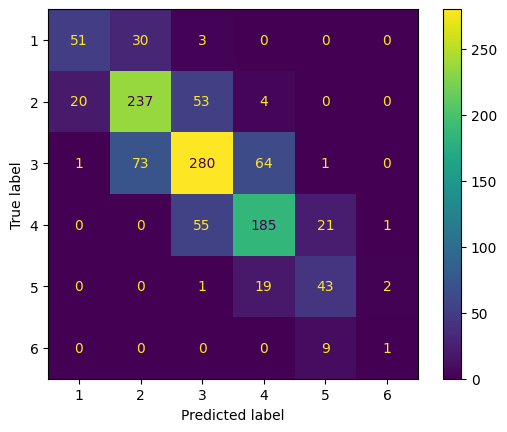

F1 score across fold: 0.688910626319775
Cohen kappa score across fold: 0.8432849229552105
fold 7
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.246698	valid's QWK: 0.227928
[50]	train's QWK: 0.666918	valid's QWK: 0.657305
[75]	train's QWK: 0.715231	valid's QWK: 0.707422
[100]	train's QWK: 0.755067	valid's QWK: 0.745975
[125]	train's QWK: 0.776772	valid's QWK: 0.760397
[150]	train's QWK: 0.793371	valid's QWK: 0.775828
[175]	train's QWK: 0.807623	valid's QWK: 0.78686
[200]	train's QWK: 0.816464	valid's QWK: 0.798412
[225]	train's QWK: 0.822178	valid's QWK: 0.80117
[250]	train's QWK: 0.826046	valid's QWK: 0.804396
[275]	train's QWK: 0.82917	valid's QWK: 0.806372
[300]	train's QWK: 0.831096	valid's QWK: 0.80635
[325]	train's QWK: 0.833075	valid's QWK: 0.80889
[350]	train's QWK: 0.834901	valid's QWK: 0.810848
[375]	train's QWK: 0.836269	valid's QWK: 0.812875
[400]	train's QWK: 0.837935	valid's QWK: 0.8

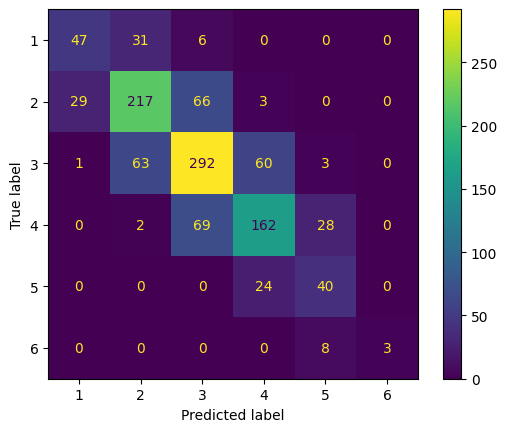

F1 score across fold: 0.6588099525321087
Cohen kappa score across fold: 0.8230022922591955
fold 8
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.223768	valid's QWK: 0.246242
[50]	train's QWK: 0.671932	valid's QWK: 0.653457
[75]	train's QWK: 0.718871	valid's QWK: 0.700017
[100]	train's QWK: 0.756734	valid's QWK: 0.735749
[125]	train's QWK: 0.774072	valid's QWK: 0.766612
[150]	train's QWK: 0.792281	valid's QWK: 0.78745
[175]	train's QWK: 0.807943	valid's QWK: 0.803666
[200]	train's QWK: 0.817669	valid's QWK: 0.81485
[225]	train's QWK: 0.822251	valid's QWK: 0.816666
[250]	train's QWK: 0.826565	valid's QWK: 0.821249
[275]	train's QWK: 0.829332	valid's QWK: 0.824851
[300]	train's QWK: 0.83174	valid's QWK: 0.825733
[325]	train's QWK: 0.833178	valid's QWK: 0.827058
[350]	train's QWK: 0.834325	valid's QWK: 0.828027
[375]	train's QWK: 0.836438	valid's QWK: 0.827667
[400]	train's QWK: 0.837576	valid's QWK: 

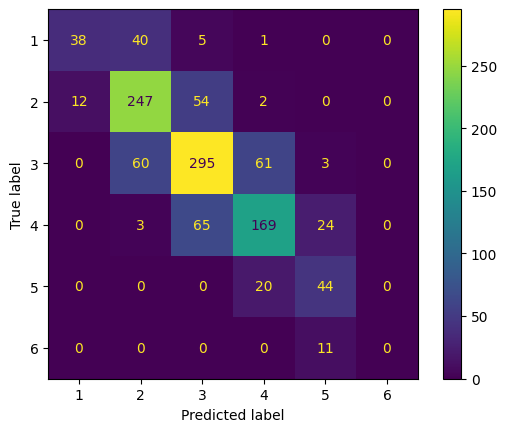

F1 score across fold: 0.6818435734012843
Cohen kappa score across fold: 0.8296103234361079
fold 9
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.197585	valid's QWK: 0.189905
[50]	train's QWK: 0.671423	valid's QWK: 0.65215
[75]	train's QWK: 0.721218	valid's QWK: 0.694222
[100]	train's QWK: 0.758559	valid's QWK: 0.74751
[125]	train's QWK: 0.777133	valid's QWK: 0.764693
[150]	train's QWK: 0.79421	valid's QWK: 0.779455
[175]	train's QWK: 0.808339	valid's QWK: 0.789502
[200]	train's QWK: 0.816112	valid's QWK: 0.797866
[225]	train's QWK: 0.821608	valid's QWK: 0.802258
[250]	train's QWK: 0.826643	valid's QWK: 0.807377
[275]	train's QWK: 0.829371	valid's QWK: 0.806616
[300]	train's QWK: 0.831563	valid's QWK: 0.81104
[325]	train's QWK: 0.833506	valid's QWK: 0.811672
[350]	train's QWK: 0.834782	valid's QWK: 0.814241
[375]	train's QWK: 0.836712	valid's QWK: 0.813457
[400]	train's QWK: 0.837866	valid's QWK: 0

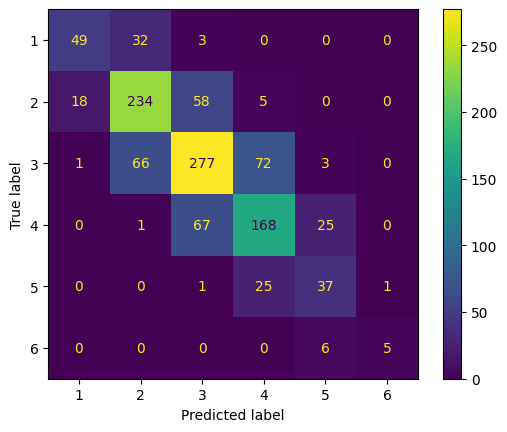

F1 score across fold: 0.6670081068555871
Cohen kappa score across fold: 0.8279397528036562
fold 10
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.224015	valid's QWK: 0.203118
[50]	train's QWK: 0.661142	valid's QWK: 0.649303
[75]	train's QWK: 0.712166	valid's QWK: 0.704174
[100]	train's QWK: 0.756122	valid's QWK: 0.753297
[125]	train's QWK: 0.775212	valid's QWK: 0.771178
[150]	train's QWK: 0.793513	valid's QWK: 0.79006
[175]	train's QWK: 0.808088	valid's QWK: 0.806011
[200]	train's QWK: 0.818135	valid's QWK: 0.809792
[225]	train's QWK: 0.823023	valid's QWK: 0.817353
[250]	train's QWK: 0.826931	valid's QWK: 0.826432
[275]	train's QWK: 0.829837	valid's QWK: 0.824386
[300]	train's QWK: 0.831995	valid's QWK: 0.825903
[325]	train's QWK: 0.833459	valid's QWK: 0.826262
[350]	train's QWK: 0.834902	valid's QWK: 0.826349
[375]	train's QWK: 0.835857	valid's QWK: 0.828211
[400]	train's QWK: 0.837566	valid's QW

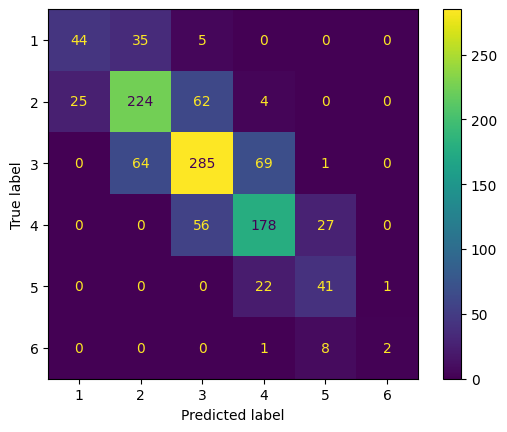

F1 score across fold: 0.6692662390571485
Cohen kappa score across fold: 0.8329600711055782
fold 11
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.225798	valid's QWK: 0.218703
[50]	train's QWK: 0.67198	valid's QWK: 0.674432
[75]	train's QWK: 0.717412	valid's QWK: 0.713891
[100]	train's QWK: 0.757632	valid's QWK: 0.746348
[125]	train's QWK: 0.777236	valid's QWK: 0.773739
[150]	train's QWK: 0.79394	valid's QWK: 0.787093
[175]	train's QWK: 0.80912	valid's QWK: 0.80445
[200]	train's QWK: 0.816279	valid's QWK: 0.814699
[225]	train's QWK: 0.822124	valid's QWK: 0.816483
[250]	train's QWK: 0.825723	valid's QWK: 0.821886
[275]	train's QWK: 0.829206	valid's QWK: 0.819574
[300]	train's QWK: 0.831978	valid's QWK: 0.823367
[325]	train's QWK: 0.833511	valid's QWK: 0.825048
[350]	train's QWK: 0.835025	valid's QWK: 0.827327
[375]	train's QWK: 0.836477	valid's QWK: 0.82803
[400]	train's QWK: 0.838411	valid's QWK: 0

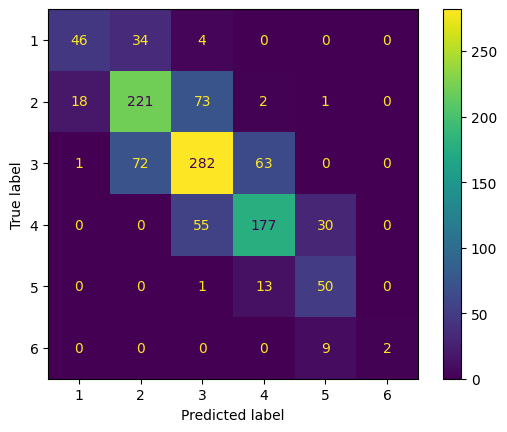

F1 score across fold: 0.6725217610497236
Cohen kappa score across fold: 0.8359031266903478
fold 12
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.250778	valid's QWK: 0.225043
[50]	train's QWK: 0.662293	valid's QWK: 0.654728
[75]	train's QWK: 0.717417	valid's QWK: 0.719329
[100]	train's QWK: 0.755131	valid's QWK: 0.756115
[125]	train's QWK: 0.776867	valid's QWK: 0.769811
[150]	train's QWK: 0.794335	valid's QWK: 0.793039
[175]	train's QWK: 0.808848	valid's QWK: 0.809683
[200]	train's QWK: 0.816539	valid's QWK: 0.815139
[225]	train's QWK: 0.821442	valid's QWK: 0.823126
[250]	train's QWK: 0.825047	valid's QWK: 0.830755
[275]	train's QWK: 0.827979	valid's QWK: 0.831749
[300]	train's QWK: 0.830245	valid's QWK: 0.836055
[325]	train's QWK: 0.832604	valid's QWK: 0.838847
[350]	train's QWK: 0.834829	valid's QWK: 0.836205
[375]	train's QWK: 0.836281	valid's QWK: 0.835628
[400]	train's QWK: 0.837703	valid's Q

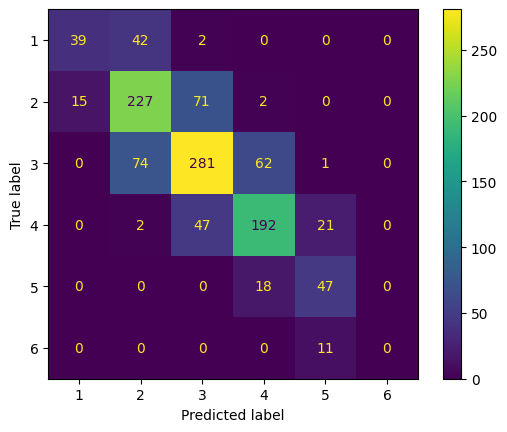

F1 score across fold: 0.6764379887685373
Cohen kappa score across fold: 0.8393329453610469
fold 13
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.22569	valid's QWK: 0.233492
[50]	train's QWK: 0.660158	valid's QWK: 0.652018
[75]	train's QWK: 0.713342	valid's QWK: 0.726401
[100]	train's QWK: 0.753907	valid's QWK: 0.757436
[125]	train's QWK: 0.773186	valid's QWK: 0.780673
[150]	train's QWK: 0.790049	valid's QWK: 0.797019
[175]	train's QWK: 0.805343	valid's QWK: 0.808757
[200]	train's QWK: 0.814432	valid's QWK: 0.814668
[225]	train's QWK: 0.821513	valid's QWK: 0.817932
[250]	train's QWK: 0.8254	valid's QWK: 0.818239
[275]	train's QWK: 0.828867	valid's QWK: 0.82389
[300]	train's QWK: 0.831387	valid's QWK: 0.828217
[325]	train's QWK: 0.832759	valid's QWK: 0.827883
[350]	train's QWK: 0.834938	valid's QWK: 0.829186
[375]	train's QWK: 0.836222	valid's QWK: 0.829272
[400]	train's QWK: 0.837385	valid's QWK: 

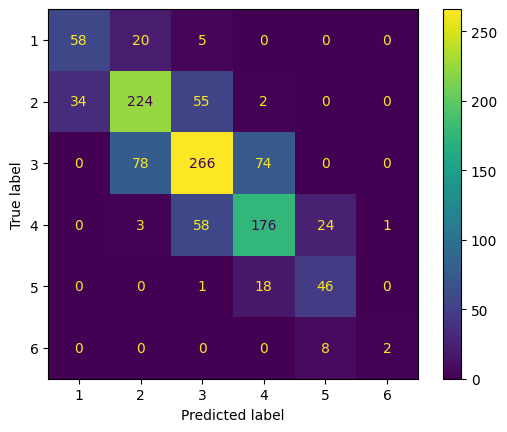

F1 score across fold: 0.6684276999654896
Cohen kappa score across fold: 0.8366900456200381
fold 14
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.195118	valid's QWK: 0.196046
[50]	train's QWK: 0.662875	valid's QWK: 0.676093
[75]	train's QWK: 0.718684	valid's QWK: 0.729329
[100]	train's QWK: 0.753395	valid's QWK: 0.766253
[125]	train's QWK: 0.771026	valid's QWK: 0.784808
[150]	train's QWK: 0.794051	valid's QWK: 0.807725
[175]	train's QWK: 0.806985	valid's QWK: 0.820094
[200]	train's QWK: 0.814665	valid's QWK: 0.826393
[225]	train's QWK: 0.821169	valid's QWK: 0.834479
[250]	train's QWK: 0.824425	valid's QWK: 0.837896
[275]	train's QWK: 0.826654	valid's QWK: 0.839157
[300]	train's QWK: 0.828408	valid's QWK: 0.840253
[325]	train's QWK: 0.831014	valid's QWK: 0.843085
[350]	train's QWK: 0.833049	valid's QWK: 0.845696
[375]	train's QWK: 0.834498	valid's QWK: 0.847534
[400]	train's QWK: 0.836212	valid's Q

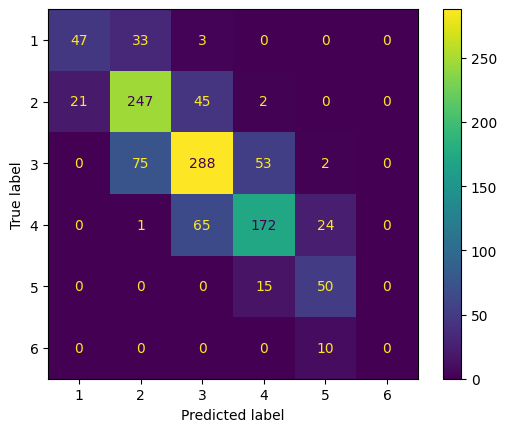

F1 score across fold: 0.6933445370230906
Cohen kappa score across fold: 0.8486826063933657
fold 15
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.247357	valid's QWK: 0.290641
[50]	train's QWK: 0.667043	valid's QWK: 0.688579
[75]	train's QWK: 0.720607	valid's QWK: 0.749491
[100]	train's QWK: 0.755379	valid's QWK: 0.785361
[125]	train's QWK: 0.774566	valid's QWK: 0.803226
[150]	train's QWK: 0.791007	valid's QWK: 0.81322
[175]	train's QWK: 0.805792	valid's QWK: 0.832081
[200]	train's QWK: 0.815112	valid's QWK: 0.839651
[225]	train's QWK: 0.821103	valid's QWK: 0.842116
[250]	train's QWK: 0.824986	valid's QWK: 0.844979
[275]	train's QWK: 0.827651	valid's QWK: 0.84519
[300]	train's QWK: 0.830098	valid's QWK: 0.843557
[325]	train's QWK: 0.832138	valid's QWK: 0.843983
[350]	train's QWK: 0.833224	valid's QWK: 0.845374
Early stopping, best iteration is:
[276]	train's QWK: 0.827684	valid's QWK: 0.84614
Evalu

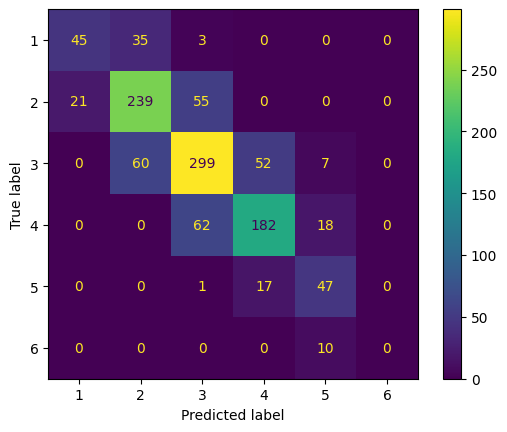

F1 score across fold: 0.7006859202053799
Cohen kappa score across fold: 0.8461399583971114
Mean F1 score across 15 folds: 0.672317826480112
Mean Cohen kappa score across 15 folds: 0.835755328542907


In [26]:
n_splits = 15

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

f1_scores = []
kappa_scores = []
models = []
predictions = []
callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]

i=1
for train_index, test_index in skf.split(X, y_split):
   
    print('fold',i)
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    
   
    y_train_fold, y_test_fold, y_test_fold_int = y[train_index], y[test_index], y_split[test_index]
    
    model = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = 0.01,
                max_depth = 5,
                num_leaves = 10,
                colsample_bytree=0.3,
                reg_alpha = 0.7,
                reg_lambda = 0.1,
                n_estimators=700,
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                verbosity = - 1)

    predictor = model.fit(X_train_fold,
                                  y_train_fold,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
                                  eval_metric=quadratic_weighted_kappa,
                                  callbacks=callbacks,)
    models.append(predictor)
    predictions_fold = predictor.predict(X_test_fold)
    predictions_fold = predictions_fold + a
    oof[test_index]=predictions_fold
    predictions_fold = predictions_fold.clip(1, 6).round()
    predictions.append(predictions_fold)
    f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
    f1_scores.append(f1_fold)
    
    
    kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
    kappa_scores.append(kappa_fold)
    
    cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[x for x in range(1,7)])
    disp.plot()
    plt.show()
    print(f'F1 score across fold: {f1_fold}')
    print(f'Cohen kappa score across fold: {kappa_fold}')
    i+=1

mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)

print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')

In [27]:
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

In [28]:
with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

# **Inference**

In [29]:
# Paragraph
tmp = Paragraph_Preprocess(test)
test_feats = Paragraph_Eng(tmp)
# Sentence
tmp = Sentence_Preprocess(test)
test_feats = test_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')
# Word
tmp = Word_Preprocess(test)
test_feats = test_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

# Tfidf
test_tfid = vectorizer.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

# CountVectorizer
test_tfid = vectorizer_cnt.transform([i for i in test['full_text']])
dense_matrix = test_tfid.toarray()
df = pd.DataFrame(dense_matrix)
tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
df.columns = tfid_columns
df['essay_id'] = test_feats['essay_id']
test_feats = test_feats.merge(df, on='essay_id', how='left')

for i in range(6):
    test_feats[f'deberta_oof_{i}'] = predicted_score[:, i]

# Features number
feature_names = list(filter(lambda x: x not in ['essay_id','score'], test_feats.columns))
print('Features number: ',len(feature_names))


Features number:  21905


## Generating Submission File


In [30]:
probabilities = []
for model in models:
    proba= model.predict(test_feats[feature_select])+ a
    probabilities.append(proba)

predictions = np.mean(probabilities, axis=0)

predictions = np.round(predictions.clip(1, 6))

print(predictions)

[2. 3. 4.]


In [31]:
submission=pd.read_csv("/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv")
submission['score']=predictions
submission['score']=submission['score'].astype(int)
submission.to_csv("submission.csv",index=None)
